# Projet Green AI : Robot de Tri de Déchets sur Plage 🏖️♻️

## 📘 **Introduction**

Ce notebook présente l’ensemble du pipeline développé pour entraîner et évaluer des modèles de deep learning appliqués à la classification d’images de déchets dans un contexte d’environnement simulé.  
L’objectif principal est d’explorer différentes architectures — notamment **MobileNetV2** et **ResNet18** — afin d’optimiser la performance tout en mesurant l’impact environnemental de leur entraînement grâce à **CodeCarbon**.

Pour renforcer la robustesse des modèles face à des variations de terrain, un **dataset artificiel avec fond de sable** a été généré à partir du dataset d’origine. Ce travail inclut :

- la création d’un pipeline automatique de remplacement d’arrière-plan (GrabCut + fond sable),
- la génération du dataset `dataset_sand`,
- la mise en place d’un split **train / val / test** cohérent,
- l’entraînement complet de plusieurs modèles avec suivi de l’empreinte carbone,
- la comparaison des impacts environnementaux (exprimés en mg/ng de CO₂),
- ainsi que l’intégration des modèles entraînés dans un **environnement de simulation Pygame** via un robot virtuel.

Ce notebook constitue donc une démonstration complète et reproductible, reliant :

- **Préparation des données**  
- **Entraînement des modèles**  
- **Analyse écologique**  
- **Visualisation des résultats**  
- **Intégration dans une application interactive**  

Il sert de base à la fois à l’analyse scientifique et au développement logiciel dans le cadre du projet de classification intelligente et durable des déchets.

In [48]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split

print("PyTorch :", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device :", device)

PROJECT_DIR = os.getcwd()
print("Project dir :", PROJECT_DIR)

PyTorch : 2.9.1+cpu
Device : cpu
Project dir : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\src


**Création du dataset**

In [8]:
# ------------------------------
# 1) Définition des dossiers
# ------------------------------

# Répertoire du projet = dossier parent de src/
PROJECT_DIR = os.path.dirname(os.getcwd())

# Dossier contenant les datasets
DATA_DIR = os.path.join(PROJECT_DIR, "dataset")

# Dataset original (images réelles)
DATASET_ORIG = os.path.join(DATA_DIR, "RealWaste")

# Dossier vide où seront stockées les images avec fond sable
DATASET_SAND = os.path.join(PROJECT_DIR, "dataset_sand")

# Dossier contenant ton image de sable (ex : sand/sand.jpg)
ASSET_DIR = os.path.join(PROJECT_DIR, "assets", "sand")


# Création du dossier dataset_sand uniquement (il doit être vide au début)
os.makedirs(DATASET_SAND, exist_ok=True)

print("📁 Dataset original :", DATASET_ORIG)
print("📁 Dataset sable BG (vide) :", DATASET_SAND)
print("📁 Dossier image de sable :", ASSET_DIR)

sand_image_path = None
for fname in os.listdir(ASSET_DIR):
    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        sand_image_path = os.path.join(ASSET_DIR, fname)
        break

if sand_image_path is None:
    raise FileNotFoundError("Aucune image (.jpg/.jpeg/.png) trouvée dans le dossier 'asset'.")

print("🖼️ Image de sable utilisée :", sand_image_path)

📁 Dataset original : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\dataset\RealWaste
📁 Dataset sable BG (vide) : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\dataset_sand
📁 Dossier image de sable : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\assets\sand
🖼️ Image de sable utilisée : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\assets\sand\sand1.jpg


**Aperçu du dataset original**

Classes détectées : ['Glass', 'Metal', 'Natural', 'Paper', 'Plastic']


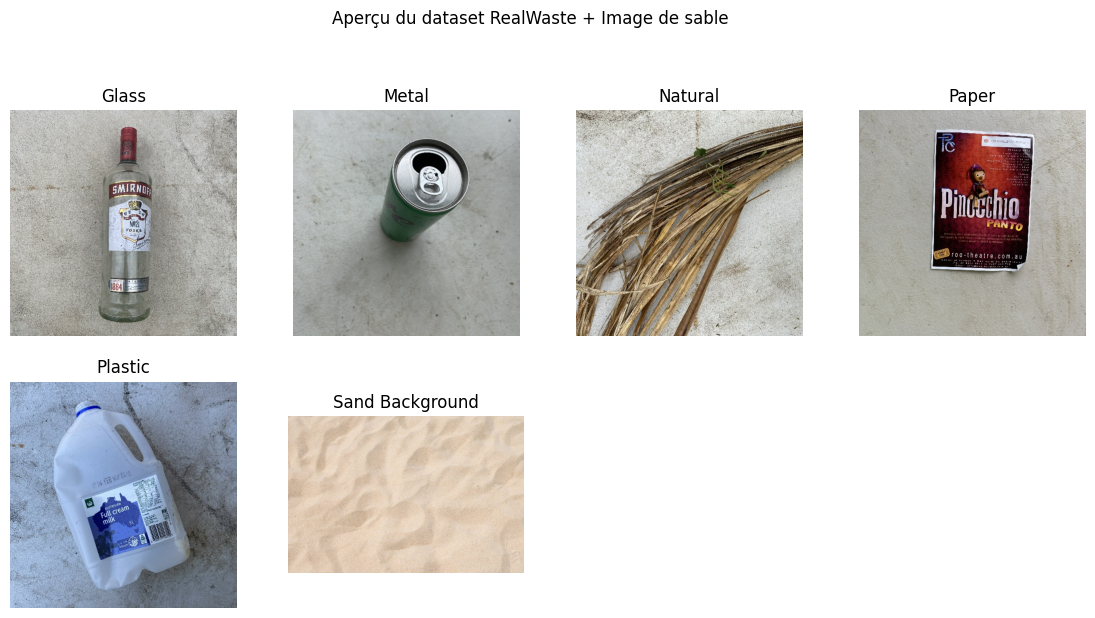

In [4]:
import os
import matplotlib.pyplot as plt

# ------------------------------
# 1) Récupération des classes du dataset original
# ------------------------------

classes = sorted([
    c for c in os.listdir(DATASET_ORIG)
    if os.path.isdir(os.path.join(DATASET_ORIG, c))
])

print("Classes détectées :", classes)

# ------------------------------
# 2) Visualisation : une image par classe + image de sable
# ------------------------------

plt.figure(figsize=(14, 10))

# Nombre total d’images affichées (classes + 1 image de sable)
total_images = min(len(classes), 9)

for i, cls in enumerate(classes[:total_images]):
    cls_dir = os.path.join(DATASET_ORIG, cls)

    # Récupère la première image du dossier
    img_name = next((f for f in os.listdir(cls_dir)
                     if f.lower().endswith((".png", ".jpg", ".jpeg"))), None)

    if img_name is None:
        continue

    img_path = os.path.join(cls_dir, img_name)
    img = plt.imread(img_path)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

# ------------------------------
# 3) Ajouter l’image de sable en dernier
# ------------------------------

sand_img = plt.imread(sand_image_path)

plt.subplot(3, 4, total_images + 1)
plt.imshow(sand_img)
plt.title("Sand Background")
plt.axis("off")

plt.suptitle("Aperçu du dataset RealWaste + Image de sable")
plt.show()


**Remplacer le fond des images en fond de sable**

In [ ]:
sand_images = [
    f for f in os.listdir(ASSET_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]
assert len(sand_images) > 0, "Le dossier Sand doit contenir des images."

def replace_background_with_sand(img_path, save_path):
    img = cv2.imread(img_path)
    if img is None:
        return

    h, w = img.shape[:2]
    mask = np.zeros((h, w), np.uint8)

    rect = (10, 10, w-20, h-20)

    bgModel = np.zeros((1,65), np.float64)
    fgModel = np.zeros((1,65), np.float64)

    try:
        cv2.grabCut(img, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
    except:
        cv2.imwrite(save_path, img)
        return

    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype("uint8")

    sand_choice = random.choice(sand_images)
    sand = cv2.imread(os.path.join(ASSET_DIR, sand_choice))
    sand = cv2.resize(sand, (w, h))

    result = sand.copy()
    result[mask2==1] = img[mask2==1]

    cv2.imwrite(save_path, result)


In [10]:
for cls in tqdm(classes, desc="Fond sable"):
    src_dir = os.path.join(DATASET_ORIG, cls)
    dst_dir = os.path.join(DATASET_SAND, cls)
    os.makedirs(dst_dir, exist_ok=True)

    for img_name in os.listdir(src_dir):
        if not img_name.lower().endswith((".jpg",".jpeg",".png")):
            continue

        src_path = os.path.join(src_dir, img_name)
        dst_path = os.path.join(dst_dir, img_name)

        if not os.path.exists(dst_path):
            replace_background_with_sand(src_path, dst_path)

print("Dataset RealWaste_sand généré ✔️")


Fond sable: 100%|██████████| 9/9 [24:02:45<00:00, 9618.34s/it]    

Dataset RealWaste_sand généré ✔️


Nombre total d'images disponibles dans dataset_sand : 3067


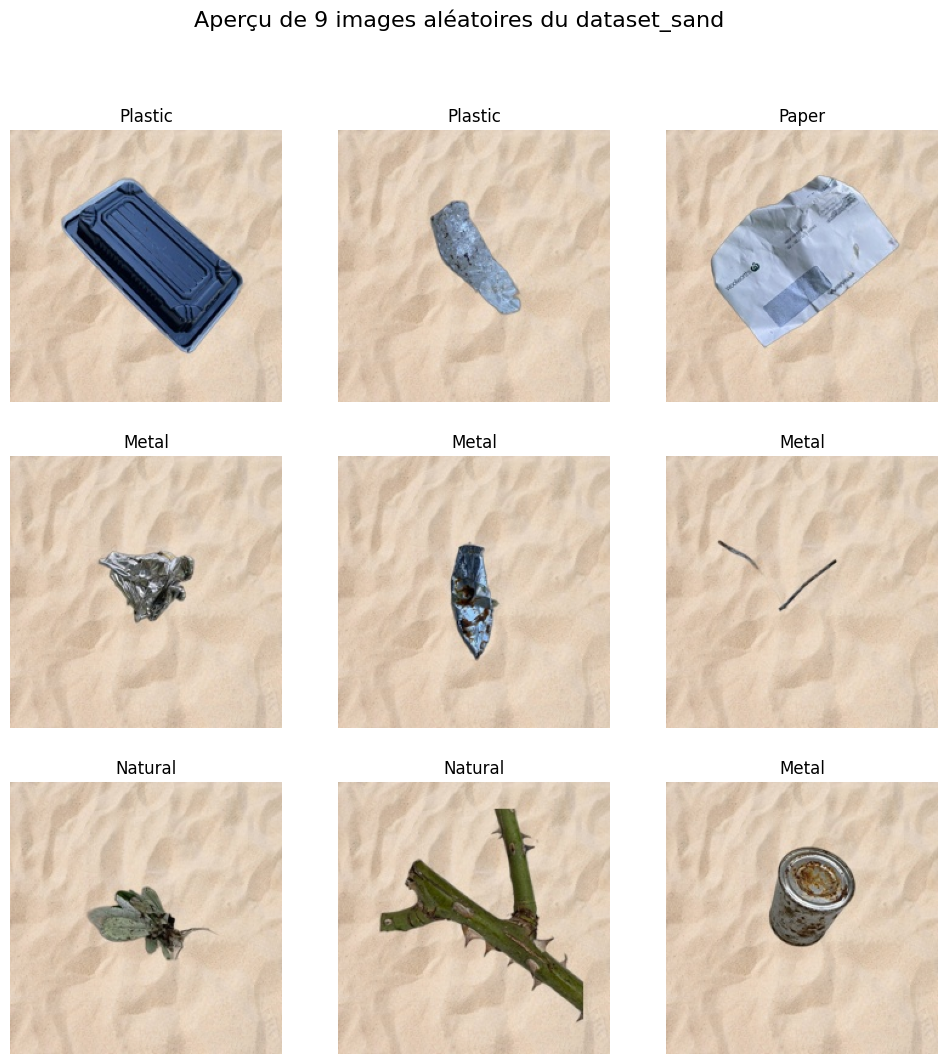

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# ------------------------------
# 1) Récupération de toutes les images dans dataset_sand
# ------------------------------

all_sand_images = []

for cls in os.listdir(DATASET_SAND):
    cls_dir = os.path.join(DATASET_SAND, cls)
    if not os.path.isdir(cls_dir):
        continue

    imgs = [
        os.path.join(cls_dir, f)
        for f in os.listdir(cls_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    all_sand_images.extend(imgs)

total = len(all_sand_images)
print(f"Nombre total d'images disponibles dans dataset_sand : {total}")

if total == 0:
    raise ValueError("❌ Aucune image trouvée dans dataset_sand. Vérifie la génération.")

# ------------------------------
# 2) Sélection de 9 images aléatoires (ou moins si dataset plus petit)
# ------------------------------

n = min(9, total)
sample_images = random.sample(all_sand_images, n)

# ------------------------------
# 3) Affichage en grille 3×3 (ou ajustée si moins de 9 images)
# ------------------------------

cols = 3
rows = (n + cols - 1) // cols  # nombre de lignes nécessaires

plt.figure(figsize=(12, 4 * rows))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(img_path)))  # nom de la classe
    plt.axis("off")

plt.suptitle(f"Aperçu de {n} images aléatoires du dataset_sand", fontsize=16)
plt.show()


**Création du jeu de données train et test**

In [10]:
import os
import shutil
from sklearn.model_selection import train_test_split

# ------------------------------
# 1) Dossiers train / test basés sur dataset_sand
# ------------------------------

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# On repart de zéro pour être sûr que le split correspond bien à dataset_sand
shutil.rmtree(TRAIN_DIR, ignore_errors=True)
shutil.rmtree(TEST_DIR, ignore_errors=True)
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

print("📁 TRAIN_DIR :", TRAIN_DIR)
print("📁 TEST_DIR  :", TEST_DIR)

# ------------------------------
# 2) Classes prises depuis dataset_sand
# ------------------------------

classes = sorted([
    c for c in os.listdir(DATASET_SAND)
    if os.path.isdir(os.path.join(DATASET_SAND, c))
])

print("Classes trouvées dans dataset_sand :", classes)

# ------------------------------
# 3) Split train / test et copie des fichiers
# ------------------------------

test_ratio = 0.2  # 20% test, 80% train

for cls in classes:
    src_dir = os.path.join(DATASET_SAND, cls)
    imgs = [
        f for f in os.listdir(src_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    if len(imgs) == 0:
        print(f"⚠️ Aucun fichier image pour la classe {cls}, ignorée.")
        continue

    train_imgs, test_imgs = train_test_split(
        imgs, test_size=test_ratio, random_state=42
    )

    train_cls_dir = os.path.join(TRAIN_DIR, cls)
    test_cls_dir  = os.path.join(TEST_DIR, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(test_cls_dir, exist_ok=True)

    for f in train_imgs:
        shutil.copy2(os.path.join(src_dir, f),
                     os.path.join(train_cls_dir, f))

    for f in test_imgs:
        shutil.copy2(os.path.join(src_dir, f),
                     os.path.join(test_cls_dir, f))

print("✅ Split train/test à partir de dataset_sand terminé.")


📁 TRAIN_DIR : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\dataset\train
📁 TEST_DIR  : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\dataset\test
Classes trouvées dans dataset_sand : ['Glass', 'Metal', 'Natural', 'Paper', 'Plastic']
✅ Split train/test à partir de dataset_sand terminé.


In [11]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)

val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train:", len(train_dataset)," Val:", len(val_dataset)," Test:", len(test_dataset))
print("Classes :", full_train_dataset.classes)
num_classes = len(full_train_dataset.classes)


Train: 1962  Val: 490  Test: 615
Classes : ['Glass', 'Metal', 'Natural', 'Paper', 'Plastic']


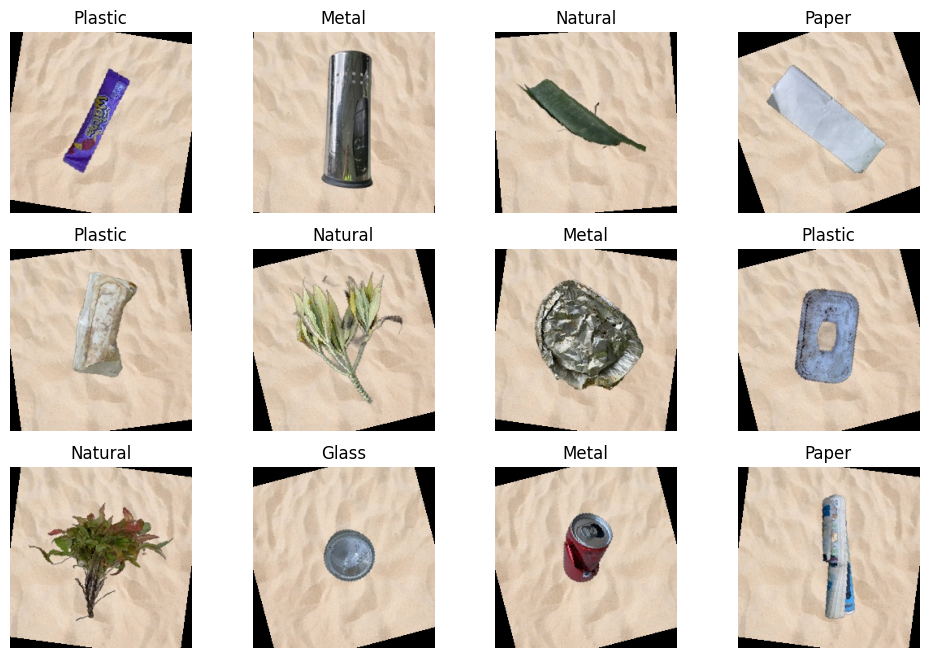

In [12]:
images, labels = next(iter(train_loader))

mean = torch.tensor([0.485,0.456,0.406]).reshape(3,1,1)
std = torch.tensor([0.229,0.224,0.225]).reshape(3,1,1)

plt.figure(figsize=(12,8))
for i in range(12):
    img = images[i] * std + mean
    img = img.permute(1,2,0).numpy()

    plt.subplot(3,4,i+1)
    plt.imshow(np.clip(img,0,1))
    plt.title(full_train_dataset.classes[labels[i]])
    plt.axis("off")

plt.show()


**Création du robot avec un fond de sable**

In [47]:
import cv2
import numpy as np
import os

# Dossier assets
ASSET_DIR = os.path.join("..", "assets", "sand")   # même dossier que ton sand1.jpg
ROBOT_PATH = os.path.join("..", "assets", "robot.png")
OUTPUT_PATH = os.path.join("..", "assets", "robot_sand.png")

# Charge robot (image avec fond blanc)
robot = cv2.imread(ROBOT_PATH)
h, w = robot.shape[:2]

# Mask pour séparer le robot du fond
mask = np.zeros((h, w), np.uint8)
rect = (10, 10, w-20, h-20)

bgModel = np.zeros((1,65), np.float64)
fgModel = np.zeros((1,65), np.float64)

try:
    cv2.grabCut(robot, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
except:
    print("GrabCut failed")
    exit()

mask2 = np.where((mask==2)|(mask==0), 0, 1).astype("uint8")

# Charger le fond de sable
sand_img_name = [f for f in os.listdir(ASSET_DIR) if f.endswith(('.jpg','.png'))][0]
sand = cv2.imread(os.path.join(ASSET_DIR, sand_img_name))
sand = cv2.resize(sand, (w, h))

# Collage : sable en fond + robot en premier plan
result = sand.copy()
result[mask2 == 1] = robot[mask2 == 1]

cv2.imwrite(OUTPUT_PATH, result)
print("✅ Image robot_sand.png générée :", OUTPUT_PATH)


✅ Image robot_sand.png générée : ..\assets\robot_sand.png


### 1 - **CNN Simple**

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28,256), nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self,x):
        x = self.features(x)
        return self.classifier(x)

cnn = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

cnn


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=5, bias=True)
  )
)

In [14]:
def train_epoch(model, loader):
    model.train()
    total, correct, loss_sum = 0,0,0

    for X,y in loader:
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()

        outputs = model(X)
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs,1)
        correct += (preds==y).sum().item()
        total += X.size(0)
        loss_sum += loss.item()*X.size(0)

    return loss_sum/total, correct/total

def eval_epoch(model, loader):
    model.eval()
    total, correct, loss_sum = 0,0,0

    with torch.no_grad():
        for X,y in loader:
            X,y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs,y)

            _, preds = torch.max(outputs,1)
            correct += (preds==y).sum().item()
            total += X.size(0)
            loss_sum += loss.item()*X.size(0)

    return loss_sum/total, correct/total


history = {"train_acc":[], "val_acc":[], "train_loss":[], "val_loss":[]}

for epoch in range(1,16):
    tr_loss, tr_acc = train_epoch(cnn, train_loader)
    val_loss, val_acc = eval_epoch(cnn, val_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"[{epoch}/15] Train Acc={tr_acc:.3f} | Val Acc={val_acc:.3f}")


[1/15] Train Acc=0.343 | Val Acc=0.488
[2/15] Train Acc=0.499 | Val Acc=0.549
[3/15] Train Acc=0.551 | Val Acc=0.578
[4/15] Train Acc=0.568 | Val Acc=0.600
[5/15] Train Acc=0.591 | Val Acc=0.602
[6/15] Train Acc=0.609 | Val Acc=0.602
[7/15] Train Acc=0.615 | Val Acc=0.608
[8/15] Train Acc=0.630 | Val Acc=0.631
[9/15] Train Acc=0.642 | Val Acc=0.610
[10/15] Train Acc=0.646 | Val Acc=0.602
[11/15] Train Acc=0.679 | Val Acc=0.671
[12/15] Train Acc=0.698 | Val Acc=0.692
[13/15] Train Acc=0.697 | Val Acc=0.690
[14/15] Train Acc=0.737 | Val Acc=0.678
[15/15] Train Acc=0.716 | Val Acc=0.696


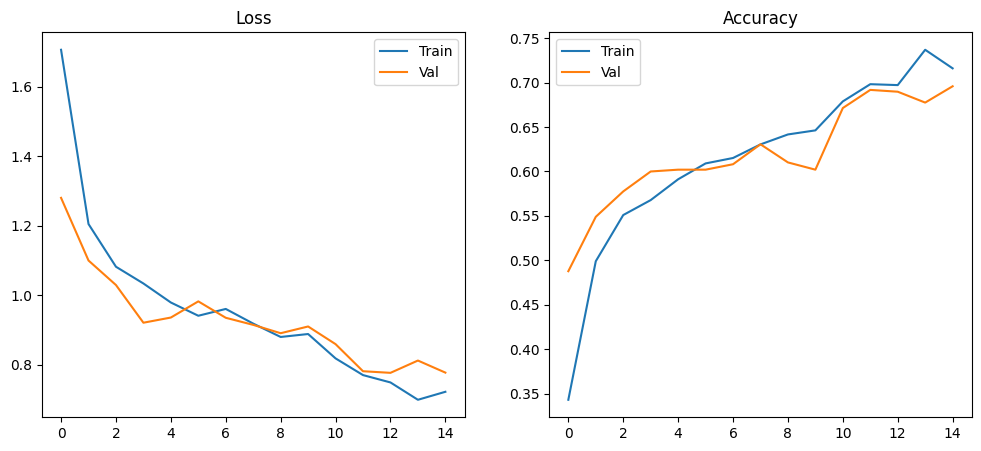

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy"); plt.legend()

plt.show()


              precision    recall  f1-score   support

       Glass       0.79      0.52      0.63        84
       Metal       0.63      0.81      0.71       158
     Natural       0.87      0.92      0.90        88
       Paper       0.63      0.65      0.64       100
     Plastic       0.67      0.58      0.62       185

    accuracy                           0.69       615
   macro avg       0.72      0.70      0.70       615
weighted avg       0.70      0.69      0.69       615



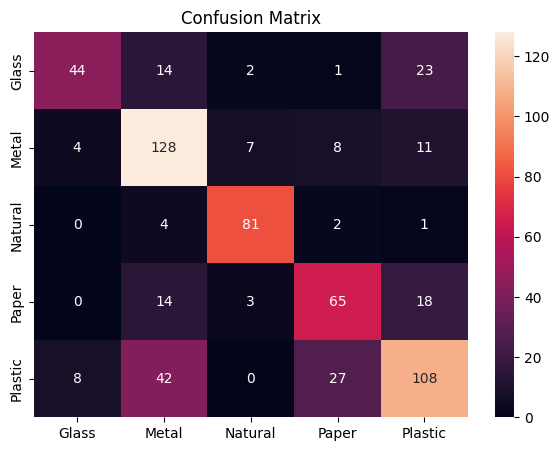

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

cnn.eval()
preds, gts = [], []

with torch.no_grad():
    for X,y in test_loader:
        X = X.to(device)
        outputs = cnn(X)
        _, batch_preds = torch.max(outputs,1)

        preds.extend(batch_preds.cpu().numpy())
        gts.extend(y.numpy())

print(classification_report(gts, preds, target_names=full_train_dataset.classes))

cm = confusion_matrix(gts, preds)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d",
    xticklabels=full_train_dataset.classes,
    yticklabels=full_train_dataset.classes)
plt.title("Confusion Matrix")
plt.show()


In [22]:
torch.save(cnn.state_dict(), "mon_modele.pth")

### 2 - **Mobile netV2**

In [31]:
import torch
import torch.nn as nn
from torchvision import models

def build_mobilenet_v2(num_classes):
    # Charger MobileNetV2 pré-entraîné
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

    # On récupère la taille de l’entrée du dernier classifier
    in_features = model.classifier[1].in_features

    # Remplacer la dernière couche par notre propre classifier
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


In [32]:
mobilenet = build_mobilenet_v2(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=1e-4)  # lr plus petit !


In [33]:
mobilenet_transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

mobilenet_transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [20]:
num_epochs = 10
history_mob = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": []
}

for epoch in range(num_epochs):
    # TRAIN
    mobilenet.train()
    running_loss, running_corrects, total = 0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = mobilenet(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * X.size(0)
        running_corrects += (preds == y).sum().item()
        total += X.size(0)

    train_loss = running_loss / total
    train_acc = running_corrects / total

    # VAL
    mobilenet.eval()
    val_loss, val_corrects, val_total = 0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = mobilenet(X)
            loss = criterion(outputs, y)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * X.size(0)
            val_corrects += (preds == y).sum().item()
            val_total += X.size(0)

    val_loss = val_loss / val_total
    val_acc = val_corrects / val_total

    history_mob["train_loss"].append(train_loss)
    history_mob["train_acc"].append(train_acc)
    history_mob["val_loss"].append(val_loss)
    history_mob["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Acc={train_acc:.3f} | Val Acc={val_acc:.3f}")


[1/10] Train Acc=0.650 | Val Acc=0.818
[2/10] Train Acc=0.812 | Val Acc=0.841
[3/10] Train Acc=0.872 | Val Acc=0.865
[4/10] Train Acc=0.914 | Val Acc=0.855
[5/10] Train Acc=0.937 | Val Acc=0.878
[6/10] Train Acc=0.949 | Val Acc=0.863
[7/10] Train Acc=0.956 | Val Acc=0.886
[8/10] Train Acc=0.963 | Val Acc=0.871
[9/10] Train Acc=0.976 | Val Acc=0.892
[10/10] Train Acc=0.976 | Val Acc=0.878


Classification report (MobileNetV2 sur test) :

              precision    recall  f1-score   support

       Glass       0.86      0.87      0.86        84
       Metal       0.82      0.94      0.88       158
     Natural       0.96      1.00      0.98        88
       Paper       0.89      0.92      0.91       100
     Plastic       0.92      0.76      0.83       185

    accuracy                           0.88       615
   macro avg       0.89      0.90      0.89       615
weighted avg       0.89      0.88      0.88       615



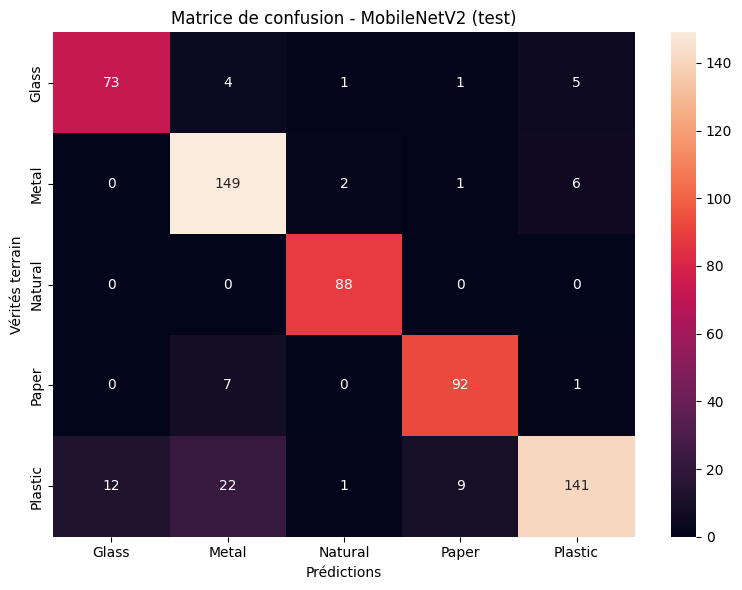

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mobilenet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:          # ← ici on utilise bien le dossier test/
        X, y = X.to(device), y.to(device)
        outputs = mobilenet(X)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification report (MobileNetV2 sur test) :\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion - MobileNetV2 (test)")
plt.tight_layout()
plt.show()


In [22]:
import os
import torch

# --- chemin vers ../models (déjà existant) ---
models_dir = os.path.join("..", "models")

# Vérifier que le dossier existe réellement
if not os.path.isdir(models_dir):
    raise FileNotFoundError(
        f"Le dossier {models_dir} n'existe pas. Vérifie ton arborescence."
    )

model_path = os.path.join(models_dir, "mobilenetv2_trash.pth")

# --- sauvegarde ---
torch.save(mobilenet.state_dict(), model_path)

print(f"✅ Modèle MobileNetV2 sauvegardé dans : {model_path}")


✅ Modèle MobileNetV2 sauvegardé dans : ..\models\mobilenetv2_trash.pth


In [34]:
from codecarbon import EmissionsTracker

num_epochs = 10  # adapte si tu veux le même nb d'epochs que dans ton notebook

# Fichier CSV de suivi CO₂ pour ce modèle
emissions_file = "emissions_mobilenetv2_sand.csv"

tracker = EmissionsTracker(
    output_dir=models_dir,                  # même dossier que tes .pth
    output_file=emissions_file,
    project_name="GreenAI_MobileNetV2_sand",
    on_csv_write="update"
)

tracker.start()

best_val_loss = float("inf")

for epoch in range(num_epochs):
    # --------- TRAIN ---------
    mobilenet.train()
    running_loss, correct, total = 0.0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = mobilenet(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # --------- VALIDATION ---------
    mobilenet.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = mobilenet(X)
            loss = criterion(outputs, y)

            val_loss += loss.item() * X.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(
        f"[MobileNetV2] Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss={train_loss:.4f} Acc={train_acc:.3f} | "
        f"Val Loss={val_loss:.4f} Acc={val_acc:.3f}"
    )

    # on écrit les métriques CO₂ à chaque epoch
    tracker.flush()

tracker.stop()
print("🎉 Suivi CO₂ terminé pour MobileNetV2.")
print(f"📁 Fichier CO₂ généré dans models/ : {emissions_file}")


[codecarbon WARNING @ 13:37:51] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:37:51] [setup] RAM Tracking...
[codecarbon INFO @ 13:37:51] [setup] CPU Tracking...
[codecarbon WARNING @ 13:37:53] We saw that you have a 13th Gen Intel(R) Core(TM) i7-13700H but we don't know it. Please contact us.
[codecarbon WARNING @ 13:37:53] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 13:37:53] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon WARNING @ 13:37:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:37:53] [setup] GPU Tracking...
[codecarbon INFO @ 13:37:53] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:37:54] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Track

[MobileNetV2] Epoch 1/10 | Train Loss=0.9080 Acc=0.651 | Val Loss=0.5106 Acc=0.816


[codecarbon INFO @ 13:39:31] Energy consumed for all GPUs : 0.000044 kWh. Total GPU Power : 5.622355144793076 W
[codecarbon INFO @ 13:39:31] 0.001310 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:39:40] Energy consumed for RAM : 0.000266 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:39:40] Delta energy consumed for CPU with constant : 0.000105 kWh, power : 42.5 W
[codecarbon INFO @ 13:39:40] Energy consumed for All CPU : 0.001129 kWh
[codecarbon INFO @ 13:39:41] Energy consumed for all GPUs : 0.000050 kWh. Total GPU Power : 2.435958977620814 W
[codecarbon INFO @ 13:39:41] 0.001445 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:39:41] 0.000809 g.CO2eq/s mean an estimation of 25.514205883747326 kg.CO2eq/year
[codecarbon INFO @ 13:39:55] Energy consumed for RAM : 0.000306 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:39:55] Delta energy consumed for CPU with constant : 0.000171 kWh, power : 

[MobileNetV2] Epoch 2/10 | Train Loss=0.4702 Acc=0.818 | Val Loss=0.4541 Acc=0.827


[codecarbon INFO @ 13:41:09] Energy consumed for all GPUs : 0.000084 kWh. Total GPU Power : 1.947523964988781 W
[codecarbon INFO @ 13:41:09] 0.002630 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 13:41:09] graceful shutdown. Exceptions:
[codecarbon WARNING @ 13:41:09] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[MobileNetV2] Epoch 3/10 | Train Loss=0.3358 Acc=0.870 | Val Loss=0.3709 Acc=0.861


[codecarbon INFO @ 13:42:45] Energy consumed for all GPUs : 0.000131 kWh. Total GPU Power : 8.086593220748455 W
[codecarbon INFO @ 13:42:45] 0.003920 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 13:42:45] graceful shutdown. Exceptions:
[codecarbon WARNING @ 13:42:45] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[MobileNetV2] Epoch 4/10 | Train Loss=0.2711 Acc=0.898 | Val Loss=0.3697 Acc=0.876


[codecarbon INFO @ 13:44:21] Energy consumed for all GPUs : 0.000169 kWh. Total GPU Power : 0.691839135953241 W
[codecarbon INFO @ 13:44:21] 0.005223 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 13:44:21] graceful shutdown. Exceptions:
[codecarbon WARNING @ 13:44:21] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[MobileNetV2] Epoch 5/10 | Train Loss=0.1911 Acc=0.936 | Val Loss=0.3801 Acc=0.873


[codecarbon INFO @ 13:48:26] Energy consumed for all GPUs : 0.000248 kWh. Total GPU Power : 10.032953478539243 W
[codecarbon INFO @ 13:48:26] 0.008760 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 13:48:26] graceful shutdown. Exceptions:
[codecarbon WARNING @ 13:48:26] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^

[MobileNetV2] Epoch 6/10 | Train Loss=0.1817 Acc=0.937 | Val Loss=0.3775 Acc=0.867


[codecarbon INFO @ 13:50:02] Energy consumed for all GPUs : 0.000298 kWh. Total GPU Power : 2.73351728201376 W
[codecarbon INFO @ 13:50:02] 0.010074 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 13:50:02] graceful shutdown. Exceptions:
[codecarbon WARNING @ 13:50:02] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^
 

[MobileNetV2] Epoch 7/10 | Train Loss=0.1509 Acc=0.946 | Val Loss=0.3874 Acc=0.849


[codecarbon INFO @ 13:51:37] Energy consumed for RAM : 0.002140 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:51:37] Delta energy consumed for CPU with constant : 0.000159 kWh, power : 42.5 W
[codecarbon INFO @ 13:51:37] Energy consumed for All CPU : 0.009098 kWh
[codecarbon INFO @ 13:51:38] Energy consumed for all GPUs : 0.000334 kWh. Total GPU Power : 0.9131996948962904 W
[codecarbon INFO @ 13:51:38] 0.011571 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:51:38] Energy consumed for all GPUs : 0.000338 kWh. Total GPU Power : 1.0808294558015097 W
[codecarbon INFO @ 13:51:38] 0.011575 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 13:51:38] graceful shutdown. Exceptions:
[codecarbon WARNING @ 13:51:38] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\sit

[MobileNetV2] Epoch 8/10 | Train Loss=0.1016 Acc=0.966 | Val Loss=0.3618 Acc=0.884


[codecarbon INFO @ 13:53:14] Energy consumed for all GPUs : 0.000379 kWh. Total GPU Power : 4.895081482206088 W
[codecarbon INFO @ 13:53:14] 0.012866 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 13:53:14] graceful shutdown. Exceptions:
[codecarbon WARNING @ 13:53:14] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[MobileNetV2] Epoch 9/10 | Train Loss=0.0993 Acc=0.962 | Val Loss=0.4357 Acc=0.867


[codecarbon INFO @ 13:54:51] Energy consumed for all GPUs : 0.000423 kWh. Total GPU Power : 2.26343083387107 W
[codecarbon INFO @ 13:54:51] 0.014178 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 13:54:51] graceful shutdown. Exceptions:
[codecarbon WARNING @ 13:54:51] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^
 

[MobileNetV2] Epoch 10/10 | Train Loss=0.0788 Acc=0.973 | Val Loss=0.4321 Acc=0.878


[codecarbon INFO @ 13:56:28] Energy consumed for all GPUs : 0.000477 kWh. Total GPU Power : 6.969242936030792 W
[codecarbon INFO @ 13:56:28] 0.015514 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 13:56:28] graceful shutdown. Exceptions:
[codecarbon WARNING @ 13:56:28] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


🎉 Suivi CO₂ terminé pour MobileNetV2.
📁 Fichier CO₂ généré dans models/ : emissions_mobilenetv2_sand.csv


### 3 - **Resnet18**

In [35]:
import torch
import torch.nn as nn
from torchvision import models

def build_resnet18(num_classes):
    # Charger ResNet18 pré-entraîné sur ImageNet
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Récupérer la taille de l'entrée de la dernière couche fully-connected
    in_features = model.fc.in_features
    
    # Remplacer la dernière couche par notre propre classifier
    model.fc = nn.Linear(in_features, num_classes)
    
    return model


In [36]:
resnet = build_resnet18(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)  # petit lr pour le fine-tuning


In [37]:
from torchvision import transforms

resnet_transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

resnet_transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [27]:
num_epochs = 10
history_res = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": []
}

for epoch in range(num_epochs):
    # ------- TRAIN -------
    resnet.train()
    running_loss, running_corrects, total = 0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = resnet(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss     += loss.item() * X.size(0)
        running_corrects += (preds == y).sum().item()
        total            += X.size(0)

    train_loss = running_loss / total
    train_acc  = running_corrects / total

    # ------- VAL -------
    resnet.eval()
    val_loss, val_corrects, val_total = 0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = resnet(X)
            loss = criterion(outputs, y)

            _, preds = torch.max(outputs, 1)
            val_loss      += loss.item() * X.size(0)
            val_corrects  += (preds == y).sum().item()
            val_total     += X.size(0)

    val_loss = val_loss / val_total
    val_acc  = val_corrects / val_total

    history_res["train_loss"].append(train_loss)
    history_res["train_acc"].append(train_acc)
    history_res["val_loss"].append(val_loss)
    history_res["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Acc={train_acc:.3f} | Val Acc={val_acc:.3f}")


[1/10] Train Acc=0.692 | Val Acc=0.767
[2/10] Train Acc=0.863 | Val Acc=0.847
[3/10] Train Acc=0.903 | Val Acc=0.871
[4/10] Train Acc=0.946 | Val Acc=0.845
[5/10] Train Acc=0.954 | Val Acc=0.843
[6/10] Train Acc=0.957 | Val Acc=0.886
[7/10] Train Acc=0.960 | Val Acc=0.880
[8/10] Train Acc=0.974 | Val Acc=0.880
[9/10] Train Acc=0.984 | Val Acc=0.873
[10/10] Train Acc=0.978 | Val Acc=0.851


Classification report (ResNet18 sur test) :

              precision    recall  f1-score   support

       Glass       0.90      0.77      0.83        84
       Metal       0.81      0.88      0.84       158
     Natural       0.99      0.98      0.98        88
       Paper       0.86      0.93      0.89       100
     Plastic       0.86      0.82      0.84       185

    accuracy                           0.87       615
   macro avg       0.88      0.88      0.88       615
weighted avg       0.87      0.87      0.87       615



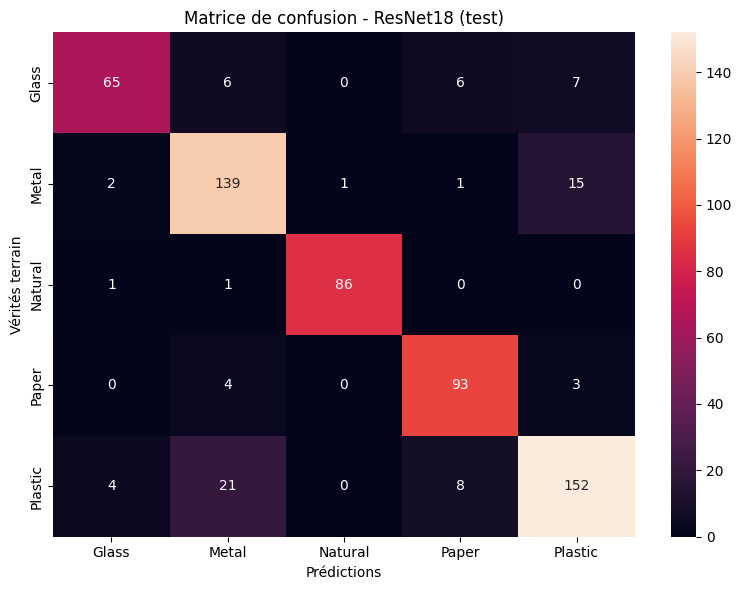

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

resnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:          # ← on utilise bien le dossier test/
        X, y = X.to(device), y.to(device)
        outputs = resnet(X)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification report (ResNet18 sur test) :\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion - ResNet18 (test)")
plt.tight_layout()
plt.show()


In [29]:
# --- chemin vers ../models (déjà existant) ---
models_dir = os.path.join("..", "models")

# Vérifier que le dossier models existe bien
if not os.path.isdir(models_dir):
    raise FileNotFoundError(
        f"Le dossier {models_dir} n'existe pas. Vérifie qu'il est au bon emplacement."
    )

# --- chemin complet du fichier .pth ---
model_path = os.path.join(models_dir, "resnet18_trash.pth")

# --- sauvegarde du modèle ---
torch.save(resnet.state_dict(), model_path)

print(f"✅ Modèle ResNet18 sauvegardé dans : {model_path}")

✅ Modèle ResNet18 sauvegardé dans : ..\models\resnet18_trash.pth


In [38]:
from codecarbon import EmissionsTracker

num_epochs = 10
history_res = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": []
}

emissions_file_res = "emissions_resnet18_sand.csv"

tracker_res = EmissionsTracker(
    output_dir=models_dir,                       # ../models
    output_file=emissions_file_res,
    project_name="ResNet18_sand_training",
    on_csv_write="update"
)

tracker_res.start()   # ⬅️ début mesure CO₂

for epoch in range(num_epochs):
    # --------- TRAIN ---------
    resnet.train()
    running_loss, running_corrects, total = 0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = resnet(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss     += loss.item() * X.size(0)
        running_corrects += (preds == y).sum().item()
        total            += X.size(0)

    train_loss = running_loss / total
    train_acc  = running_corrects / total

    # --------- VALIDATION ---------
    resnet.eval()
    val_loss, val_corrects, val_total = 0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = resnet(X)
            loss = criterion(outputs, y)

            _, preds = torch.max(outputs, 1)
            val_loss      += loss.item() * X.size(0)
            val_corrects  += (preds == y).sum().item()
            val_total     += X.size(0)

    val_loss = val_loss / val_total
    val_acc  = val_corrects / val_total

    history_res["train_loss"].append(train_loss)
    history_res["train_acc"].append(train_acc)
    history_res["val_loss"].append(val_loss)
    history_res["val_acc"].append(val_acc)

    print(
        f"[ResNet18 {epoch+1}/{num_epochs}] "
        f"Train Loss={train_loss:.4f} Acc={train_acc:.3f} | "
        f"Val Loss={val_loss:.4f} Acc={val_acc:.3f}"
    )

    tracker_res.flush()   # ⬅️ enregistre les mesures CO₂ de cette epoch

tracker_res.stop()
print("🎉 Suivi CO₂ terminé pour ResNet18.")
print(f"📁 Fichier CO₂ généré dans models/ : {emissions_file_res}")


[codecarbon WARNING @ 13:58:43] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:58:43] [setup] RAM Tracking...
[codecarbon INFO @ 13:58:43] [setup] CPU Tracking...


[codecarbon WARNING @ 13:58:45] We saw that you have a 13th Gen Intel(R) Core(TM) i7-13700H but we don't know it. Please contact us.
[codecarbon WARNING @ 13:58:45] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 13:58:45] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon WARNING @ 13:58:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:58:45] [setup] GPU Tracking...
[codecarbon INFO @ 13:58:45] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:58:46] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 13:58:46] >>> Tracker's metadata:
[codecarbon INFO @ 13:58:46]   Platform system: Windows-11-10.0.26100-

[ResNet18 1/10] Train Loss=0.7656 Acc=0.689 | Val Loss=0.4474 Acc=0.829


[codecarbon INFO @ 14:00:17] Energy consumed for RAM : 0.000230 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:00:17] Delta energy consumed for CPU with constant : 0.000138 kWh, power : 42.5 W
[codecarbon INFO @ 14:00:17] Energy consumed for All CPU : 0.000977 kWh
[codecarbon INFO @ 14:00:19] Energy consumed for all GPUs : 0.000047 kWh. Total GPU Power : 2.7725627668403074 W
[codecarbon INFO @ 14:00:19] 0.001254 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:00:32] Energy consumed for RAM : 0.000267 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:00:32] Delta energy consumed for CPU with constant : 0.000159 kWh, power : 42.5 W
[codecarbon INFO @ 14:00:32] Energy consumed for All CPU : 0.001136 kWh
[codecarbon INFO @ 14:00:34] Energy consumed for all GPUs : 0.000053 kWh. Total GPU Power : 1.4750215128563162 W
[codecarbon INFO @ 14:00:34] 0.001456 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:

[ResNet18 2/10] Train Loss=0.3808 Acc=0.860 | Val Loss=0.4540 Acc=0.810


[codecarbon INFO @ 14:01:29] Energy consumed for all GPUs : 0.000076 kWh. Total GPU Power : 2.138641937343352 W
[codecarbon INFO @ 14:01:29] 0.002213 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 14:01:29] graceful shutdown. Exceptions:
[codecarbon WARNING @ 14:01:29] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[ResNet18 3/10] Train Loss=0.2732 Acc=0.897 | Val Loss=0.4158 Acc=0.843


[codecarbon INFO @ 14:02:52] Energy consumed for all GPUs : 0.000119 kWh. Total GPU Power : 10.916584555145098 W
[codecarbon INFO @ 14:02:52] 0.003345 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 14:02:52] graceful shutdown. Exceptions:
[codecarbon WARNING @ 14:02:52] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^

[ResNet18 4/10] Train Loss=0.1715 Acc=0.943 | Val Loss=0.4083 Acc=0.849


[codecarbon INFO @ 14:04:47] Energy consumed for all GPUs : 0.000181 kWh. Total GPU Power : 2.178888374053266 W
[codecarbon INFO @ 14:04:47] 0.004959 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 14:04:47] graceful shutdown. Exceptions:
[codecarbon WARNING @ 14:04:47] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[ResNet18 5/10] Train Loss=0.1561 Acc=0.950 | Val Loss=0.4937 Acc=0.835


[codecarbon INFO @ 14:06:11] Energy consumed for all GPUs : 0.000236 kWh. Total GPU Power : 7.213608171229199 W
[codecarbon INFO @ 14:06:11] 0.006114 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:06:11] 0.000772 g.CO2eq/s mean an estimation of 24.33393877721304 kg.CO2eq/year
[codecarbon WARNING @ 14:06:11] graceful shutdown. Exceptions:
[codecarbon WARNING @ 14:06:11] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages

[ResNet18 6/10] Train Loss=0.1363 Acc=0.952 | Val Loss=0.4525 Acc=0.831


[codecarbon INFO @ 14:07:35] Energy consumed for all GPUs : 0.000267 kWh. Total GPU Power : 0.736817530910076 W
[codecarbon INFO @ 14:07:35] 0.007461 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 14:07:35] graceful shutdown. Exceptions:
[codecarbon WARNING @ 14:07:35] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[ResNet18 7/10] Train Loss=0.1102 Acc=0.966 | Val Loss=0.4473 Acc=0.849


[codecarbon INFO @ 14:08:59] Energy consumed for all GPUs : 0.000309 kWh. Total GPU Power : 2.2414178114045624 W
[codecarbon INFO @ 14:08:59] 0.008610 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 14:08:59] graceful shutdown. Exceptions:
[codecarbon WARNING @ 14:08:59] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^

[ResNet18 8/10] Train Loss=0.0786 Acc=0.975 | Val Loss=0.3622 Acc=0.869


[codecarbon INFO @ 14:10:44] Energy consumed for all GPUs : 0.000366 kWh. Total GPU Power : 11.220193410111012 W
[codecarbon INFO @ 14:10:44] 0.010076 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 14:10:44] graceful shutdown. Exceptions:
[codecarbon WARNING @ 14:10:44] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^

[ResNet18 9/10] Train Loss=0.0738 Acc=0.973 | Val Loss=0.4730 Acc=0.859


[codecarbon INFO @ 14:12:07] Energy consumed for all GPUs : 0.000404 kWh. Total GPU Power : 2.0008652939771174 W
[codecarbon INFO @ 14:12:07] 0.011208 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 14:12:07] graceful shutdown. Exceptions:
[codecarbon WARNING @ 14:12:07] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^

[ResNet18 10/10] Train Loss=0.0594 Acc=0.981 | Val Loss=0.5060 Acc=0.843


[codecarbon INFO @ 14:13:30] Energy consumed for all GPUs : 0.000449 kWh. Total GPU Power : 8.135204248323975 W
[codecarbon INFO @ 14:13:30] 0.012339 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 14:13:30] graceful shutdown. Exceptions:
[codecarbon WARNING @ 14:13:30] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


🎉 Suivi CO₂ terminé pour ResNet18.
📁 Fichier CO₂ généré dans models/ : emissions_resnet18_sand.csv


## 4 - **Comparaison et visualisation des modèles**

In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt

models_dir = os.path.join("..", "models")

file_mobilenet = os.path.join(models_dir, "emissions_mobilenetv2_sand.csv")
file_resnet    = os.path.join(models_dir, "emissions_resnet18_sand.csv")

def load_emissions_csv(filepath):
    if not os.path.isfile(filepath):
        print(f"⚠️ Fichier introuvable : {filepath}")
        return None, None
    
    df = pd.read_csv(filepath)
    
    # Détection du nom de colonne pour les émissions
    if "emissions" in df.columns:
        emissions_col = "emissions"
    elif "emissions_kg" in df.columns:
        emissions_col = "emissions_kg"
    else:
        raise ValueError(f"Aucune colonne 'emissions' ou 'emissions_kg' dans {filepath}")
    
    # Gestion du temps (optionnel mais propre)
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.sort_values("timestamp")
    
    return df, emissions_col

df_mob, col_mob = load_emissions_csv(file_mobilenet)
df_res, col_res = load_emissions_csv(file_resnet)

print("MobileNetV2 colonnes :", None if df_mob is None else df_mob.columns.tolist())
print("ResNet18 colonnes    :", None if df_res is None else df_res.columns.tolist())


MobileNetV2 colonnes : ['timestamp', 'project_name', 'run_id', 'experiment_id', 'duration', 'emissions', 'emissions_rate', 'cpu_power', 'gpu_power', 'ram_power', 'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed', 'water_consumed', 'country_name', 'country_iso_code', 'region', 'cloud_provider', 'cloud_region', 'os', 'python_version', 'codecarbon_version', 'cpu_count', 'cpu_model', 'gpu_count', 'gpu_model', 'longitude', 'latitude', 'ram_total_size', 'tracking_mode', 'on_cloud', 'pue', 'wue']
ResNet18 colonnes    : ['timestamp', 'project_name', 'run_id', 'experiment_id', 'duration', 'emissions', 'emissions_rate', 'cpu_power', 'gpu_power', 'ram_power', 'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed', 'water_consumed', 'country_name', 'country_iso_code', 'region', 'cloud_provider', 'cloud_region', 'os', 'python_version', 'codecarbon_version', 'cpu_count', 'cpu_model', 'gpu_count', 'gpu_model', 'longitude', 'latitude', 'ram_total_size', 'tracking_mode', 'on_cloud', 'pue

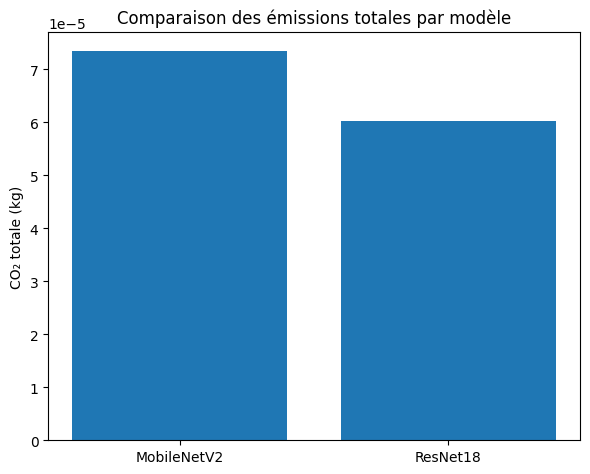

MobileNetV2 → 0.0001 kg de CO₂
ResNet18 → 0.0001 kg de CO₂


In [41]:
models = []
totals = []

if df_mob is not None:
    total_mob = df_mob[col_mob].sum()
    models.append("MobileNetV2")
    totals.append(total_mob)

if df_res is not None:
    total_res = df_res[col_res].sum()
    models.append("ResNet18")
    totals.append(total_res)

plt.figure(figsize=(6, 5))
plt.bar(models, totals)
plt.ylabel("CO₂ totale (kg)")
plt.title("Comparaison des émissions totales par modèle")
plt.tight_layout()
plt.show()

for name, t in zip(models, totals):
    print(f"{name} → {t:.4f} kg de CO₂")


Nombre d'inférences par an : 156
MobileNetV2 ~ 11447.76 mg CO₂ / an
ResNet18 ~ 9393.52 mg CO₂ / an


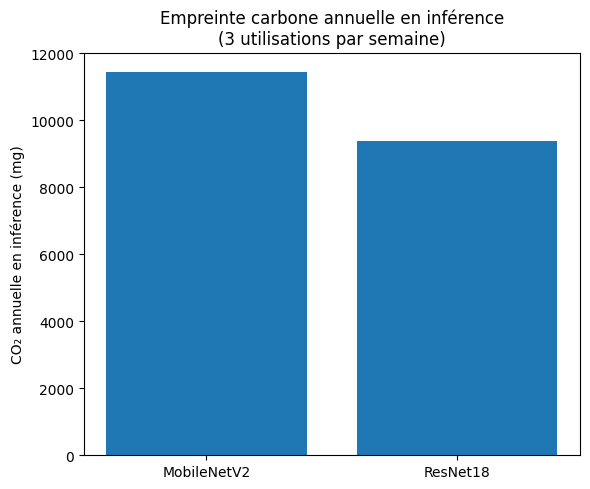

In [46]:
import matplotlib.pyplot as plt

# Hypothèse : 3 utilisations par semaine
uses_per_week = 3
weeks_per_year = 52
n_calls_per_year = uses_per_week * weeks_per_year
print(f"Nombre d'inférences par an : {n_calls_per_year}")

KG_TO_MG = 1_000_000  # 1 kg = 1e6 mg

models = []
yearly_totals_mg = []

# MobileNetV2
if df_mob is not None:
    # Approximation : une "mesure" de CodeCarbon ≈ coût carbone d'une inférence
    co2_per_call_mob_kg = df_mob[col_mob].mean()
    co2_year_mob_kg = co2_per_call_mob_kg * n_calls_per_year
    co2_year_mob_mg = co2_year_mob_kg * KG_TO_MG

    models.append("MobileNetV2")
    yearly_totals_mg.append(co2_year_mob_mg)

    print(f"MobileNetV2 ~ {co2_year_mob_mg:.2f} mg CO₂ / an")

# ResNet18
if df_res is not None:
    co2_per_call_res_kg = df_res[col_res].mean()
    co2_year_res_kg = co2_per_call_res_kg * n_calls_per_year
    co2_year_res_mg = co2_year_res_kg * KG_TO_MG

    models.append("ResNet18")
    yearly_totals_mg.append(co2_year_res_mg)

    print(f"ResNet18 ~ {co2_year_res_mg:.2f} mg CO₂ / an")

# --- Barplot annuel en mg ---
plt.figure(figsize=(6, 5))
plt.bar(models, yearly_totals_mg)
plt.ylabel("CO₂ annuelle en inférence (mg)")
plt.title("Empreinte carbone annuelle en inférence\n(3 utilisations par semaine)")
plt.tight_layout()
plt.show()
